# Financial Econometrics 2 - Project 2
## Matyáš Mattanelli & Jan Kubal

**Part A)**

*Old Assignment:*
Use same data as in Project 1, Estimate time varying OLS HAR. Find the kernel bandwidth minimizing out of smaple MSE, HAR horizons 1, 5, 22. 

---

## Project 2 - Instructions

**Details:** Students are encouraged to form a group of two for project 2 which will be assigned in three small parts during the semester. Evaluation of this project will be during the final exam, when students will present and discuss their results.

### Part A:
Construct the TV-HAR model with tvOLS (or with any other function). Find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

### Part B:
Estimate time-varying volatility of stock price time series (or an index) using the Stochastic volatility model. You can take the specification from lecture notes (Lecture 9), or you can define your own. For this task, you can use R package "stochvol" or you can use any other tool for state space models.

Perform also an out-of-sample forecast (horizon 1, 5, 22) and compare the forecasting performance with a GARCH family model of your choice.

### Part C:
Construct the TV-HAR model using the QBLL estimator. Compare the out-of-sample forecast performance with models in **Part A** of Project 2.

### Final: Fusion of Project 1 and Project 2:
Compare the prediction performance of all TV models in this project with the best neural network model from Project 1.

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
#Pkg.instantiate() #In case the environment is activated for the first time
include("utils.jl")

  Activating project at `d:\Dokumenty\Vejška\Magisterské studium\Financial Econometrics 2\Project2`


[> Loaded d:\Dokumenty\Vejška\Magisterské studium\Financial Econometrics 2\Project2\utils.jl


In [148]:
import CSV
import DataFrames
import Plots
import StatsPlots

In [150]:
using Plots
using RCall
R"library(tvReg)"

┌ Warning: RCall.jl: Warning: package 'tvReg' was built under R version 4.1.3
│ Loading required package: Matrix
│ Funded by the Horizon 2020. Framework Programme of the European Union.
│ 
└ @ RCall C:\Users\kubal\.julia\packages\RCall\Wyd74\src\io.jl:172


RObject{StrSxp}
[1] "tvReg"     "Matrix"    "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     


## Part A

In the first part we construct the TV-HAR model with tvOLS. We find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

The underlying asset is VanEck Oil Services ETF (OIH), which is an ETF aiming to reflect the overall market performance of US oil industry-related firms. Five years (January 2012 to December 2017) of 1-minute intraday prices were acquired from [kibot.com](http://www.kibot.com/free_historical_data.aspx).

We start with loading the data, computing the daily Realized Variance and creating the variables for HAR model (lagged versions of RV)

In [75]:
#Load data
data_OIH = CSV.read("OIH_adjusted_cut.csv", DataFrames.DataFrame; header=false);
data_OIH[1:5,:]

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String15,Time,Float64,Float64,Float64,Float64,Int64
1,01/03/2012,07:31:00,668.19,668.19,668.19,668.19,18
2,01/03/2012,08:00:00,648.82,648.82,648.82,648.82,35
3,01/03/2012,08:08:00,659.61,659.61,659.61,659.61,18
4,01/03/2012,09:01:00,662.71,662.71,662.71,662.71,159
5,01/03/2012,09:02:00,662.71,662.71,662.71,662.71,177


In [76]:
#Calcualate RV 
target = get_RV_from_kibot(data_OIH, returns_log = false);

In [77]:
#Compute HAR regressors
predictors = HAR_regressors(target)
predictors = Float64.(predictors)

#Shift the target
target = target[23:end]
target = Float64.(target);

In [275]:
##getting the tvOLS function form RV
function get_tvLM_MSE(horizon, bandwith; predictors = predictors, target = target)

    predictors_train = predictors[1:end-horizon, :]

    predictors_test = predictors[end-horizon+1:end, :]


    target_train = target[1:end-horizon]
    target_test = target[end-horizon+1:end]

    # println(size(predictors_train))
    # println(size(predictors_test))
    # println(size(target_train))
    # println(size(target_test))

    R""" #the function automatically includes intercept
    tv_ols <- tvLM($target_train ~  $(predictors_train[:,1]) + $(predictors_train[:,2]) + $(predictors_train[:,3]), bw = $bandwith, est = 'll')
    preds = forecast(tv_ols, $predictors_test, n.ahead = $horizon)
    #print(tv_ols$coefficients) prints out the coefficients
    """
    preds = convert(Array{Float64},R"preds")
    #println(preds)
    
    MSE = sum((preds .- target_test).^2)/length(preds)
    return MSE
end

#get_tvLM_MSE(5, 1)


3.3109410928008874e-8

In [282]:
#Finding the optimal windowsize(bandwidth) for each horizon
function try_windows(min_wind, max_wind, horizon; predictors = predictors, target = target, verbose = true)
    windows = zeros(0)
    MSEs = zeros(0)

    for window_size = min_wind:max_wind
        if verbose
            println("window $window_size out of $max_wind for horizon $horizon") 
        end
        
        MSE_iter = get_tvLM_MSE(horizon , window_size, predictors = predictors, target = target)
        #println(MSE_iter)

        append!(windows, window_size)
        append!(MSEs, MSE_iter)
    end

    return windows, MSEs
end

#winds, mses = try_windows(1, 10, 5); #change max window to size(predictors)[1]/2 later..or something like 100 might be enough


try_windows (generic function with 1 method)

In [292]:
#Finding the best window for given horizon and windows
function get_best_window(min_wind, max_wind, horizon; plot_mses = true, predictors = predictors, target = target, verbose = true)
    winds, mses = try_windows(min_wind, max_wind, horizon, predictors = predictors, target = target, verbose = verbose)

    best_mse = minimum(mses)
    best_wind = winds[argmin(mses)]

    if plot_mses
        display(plot(winds, mses) )
    end

    return best_wind, best_mse
end

#get_best_window(10, 15, 5)

get_best_window (generic function with 1 method)

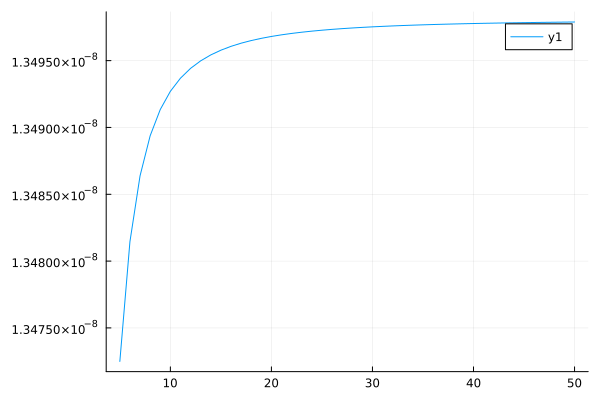

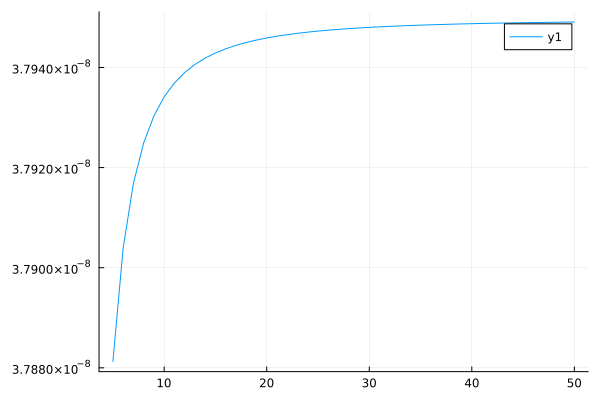

For horizon 1 found optimum window 5.0, MSE 1.3472493222919356e-8


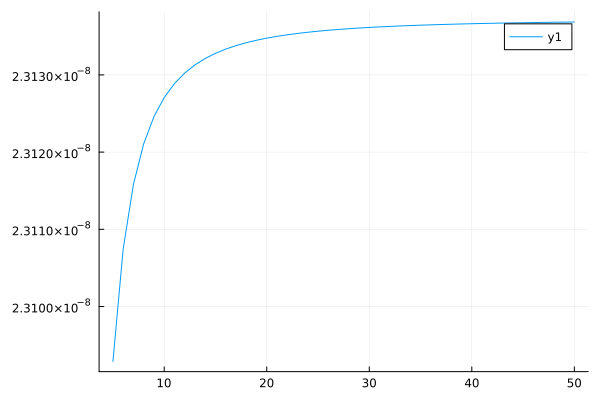

For horizon 1 found optimum window 5.0, MSE 3.788127508449654e-8


For horizon 1 found optimum window 5.0, MSE 2.309288098153931e-8


In [294]:
#runtime 2:30
optimum_hor_1 = get_best_window(5, 50, 1, verbose = false)
println("For horizon 1 found optimum window $(optimum_hor_1[1]), MSE $(optimum_hor_1[2])")

optimum_hor_5 = get_best_window(5, 50, 5, verbose = false)
println("For horizon 1 found optimum window $(optimum_hor_5[1]), MSE $(optimum_hor_5[2])")

optimum_hor_22 =  get_best_window(5, 50, 22, verbose = false)
println("For horizon 1 found optimum window $(optimum_hor_22[1]), MSE $(optimum_hor_22[2])")

---
## Old code

In [286]:
#Calculating basic OLS parameters

test_size = 0
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size);
#WIP - lets first do simple OLS HAR on all the data
X_train_with_int = [ones((1, size(X_train)[2])); X_train] #Add ones for intercept estimation
inv(X_train_with_int * transpose(X_train_with_int)) * X_train_with_int * transpose(y_train) #Calculate the coefficients

4×1 Matrix{Float64}:
 9.82056424143176e-5
 0.03884726931711059
 0.17011491520317962
 0.4588606551734476

In [287]:
#now the function from Lectures - OLSestimatorconst
function OLSestimatorconst(y,x)
    x=[ones(size(x)[1]) x]
    return (transpose(x)*x) \ (transpose(x)*y)
end

OLSestimatorconst(target, predictors) #okk, we have working OLS HAR...now the Time variing part

4-element Vector{Float64}:
 9.820564033301494e-5
 0.03884727254180133
 0.17011492517697516
 0.45886064803361076

In [288]:
#now lets do the basic Rolling window OLS
window_size = 10
tv_parameters = zeros(size(predictors)[1]-window_size,size(predictors)[2] + 1) # plus one in the size for intercept

for i = 1:size(predictors)[1]-window_size #loop through one to end of data - window
    predictors_window = predictors[i:i+window_size-1, :] #always select subset for current window
    target_window = target[i:i+window_size-1]
    tv_parameters[i, :] = OLSestimatorconst(target_window, predictors_window) #make OLS estimate on it and save it
end
#size(tv_parameters)
#size(predictors)
#println(tv_parameters[1,:])
#println(tv_parameters[end,:])


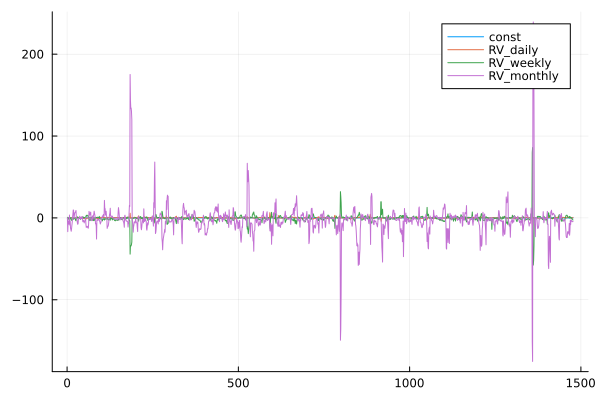

In [289]:
using Plots
plot([tv_parameters[:,1] tv_parameters[:,2] tv_parameters[:,3] tv_parameters[:,4]], label=["const" "RV_daily" "RV_weekly" "RV_monthly"])
#, tv_parameters[:,3], tv_parameters[:,4])

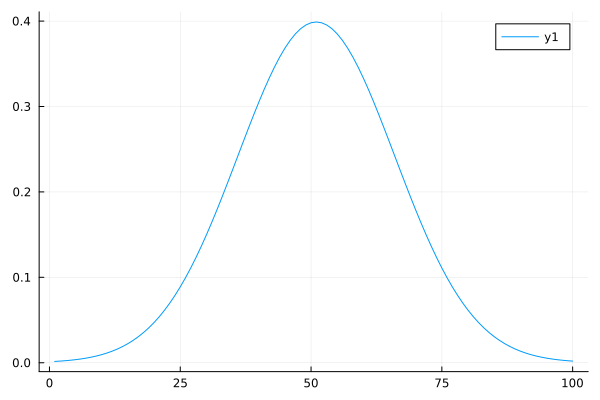

In [290]:
#Next TODO: make the poor mans version not so poor - add the kernel/smoothing
function Kernel(x,b)
    return (1/((sqrt(2*pi))))*exp(-0.5 *(x/b)^2)
end
#playing with Kernel
b=15
input = -50:49
kernel = zeros(length(1:100))
for i = 1:length(input)
    #kernel[i] = (1/((sqrt(2*pi))))*exp(-0.5 *(input[i]/b)^2)
    kernel[i] = Kernel(input[i], b)
end

plot(kernel)

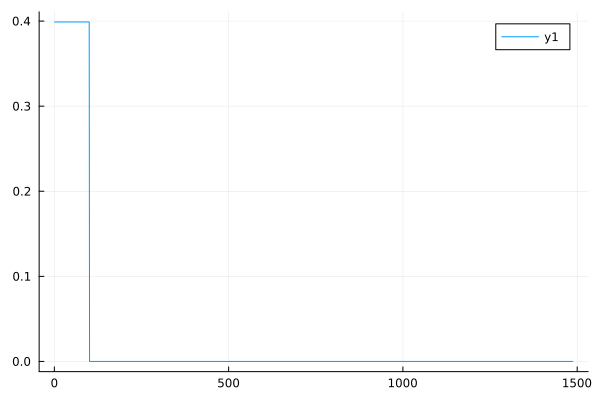

In [291]:
b=100
input = predictors[1:b, 1]
kernel = zeros(length(predictors[:, 1]))
for i = 1:length(input)
    #kernel[i] = (1/((sqrt(2*pi))))*exp(-0.5 *(input[i]/b)^2)
    kernel[i] = Kernel(input[i], b)
end

plot(predictors[1:b, 1]);
plot(kernel)

#I see, I will have to use the R package